## Libraries used

In [1]:
import pandas as pd
import numpy as np
import timesfm
from timesfm import TimesFm, TimesFmCheckpoint, TimesFmHparams
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from datetime import date
import re
import os
import xlsxwriter
import matplotlib.pyplot as plt
import yfinance as yf

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


/home/akn/miniconda3/envs/timesfm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM, likely because python version is 3.11.12 | packaged by conda-forge | (main, Apr 10 2025, 22:23:25) [GCC 13.3.0].


## Data import

In [2]:
symbol = ['GC=F', 'CL=F', '^GSPC']
df = pd.DataFrame()
for sy in symbol:
    data = yf.download(sy, 
                start='2000-12-31', 
                end='2025-05-01', 
                progress=False,
    )['Close']
    data = data.resample("MS").mean().ffill()
    data = data[sy].rename('y').to_frame()
    data['unique_id'] = sy
    df = pd.concat([df, data], axis=0)
data = df.reset_index()
data.rename(columns={'Date': 'ds'}, inplace=True)
data

/tmp/ipykernel_12504/1832307815.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(sy,
/tmp/ipykernel_12504/1832307815.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(sy,
/tmp/ipykernel_12504/1832307815.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(sy,


,ds,y,unique_id
0,2001-01-01,265.371427,GC=F
1,2001-02-01,261.805263,GC=F
2,2001-03-01,262.290907,GC=F
3,2001-04-01,261.079997,GC=F
4,2001-05-01,272.077272,GC=F
...,...,...,...
871,2024-12-01,6010.908552,^GSPC
872,2025-01-01,5979.515527,^GSPC
873,2025-02-01,6038.689967,^GSPC
874,2025-03-01,5683.983352,^GSPC


In [3]:
data_index = data[
                ['unique_id']
                            ].drop_duplicates().reset_index(drop=True)
data_index                               

,unique_id
0,GC=F
1,CL=F
2,^GSPC


## Google - TimesFM model

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
repo_id = "google/timesfm-2.0-500m-pytorch" #"google/timesfm-1.0-200m" #"timesfm-1.0-200m-pytorch" 

hparams = TimesFmHparams(
    backend=device,
    per_core_batch_size=32,
    horizon_len=12,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=50,
    model_dims=1280,
    use_positional_embedding=False,
  )
tfm = TimesFm(hparams=hparams, checkpoint=TimesFmCheckpoint(huggingface_repo_id=repo_id))

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 31823.25it/s]
/home/akn/miniconda3/envs/timesfm/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
device

'cuda'

## Train-test split

In [6]:
# Perform train-test split for each item_id
train_list = []
test_list = []

for item_id in data['unique_id'].unique():
    item_df = data[data['unique_id'] == item_id]
    train_df, test_df = train_test_split(item_df, test_size=25, shuffle=False)
    train_list.append(train_df)
    test_list.append(test_df)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

In [7]:
train_df

,ds,y,unique_id
0,2001-01-01,265.371427,GC=F
1,2001-02-01,261.805263,GC=F
2,2001-03-01,262.290907,GC=F
3,2001-04-01,261.079997,GC=F
4,2001-05-01,272.077272,GC=F
...,...,...,...
846,2022-11-01,3917.488595,^GSPC
847,2022-12-01,3912.380952,^GSPC
848,2023-01-01,3960.656531,^GSPC
849,2023-02-01,4079.684725,^GSPC


In [8]:
test_df

,ds,y,unique_id
267,2023-04-01,2001.047363,GC=F
268,2023-05-01,1993.422729,GC=F
269,2023-06-01,1941.652379,GC=F
270,2023-07-01,1950.764996,GC=F
271,2023-08-01,1917.556519,GC=F
...,...,...,...
871,2024-12-01,6010.908552,^GSPC
872,2025-01-01,5979.515527,^GSPC
873,2025-02-01,6038.689967,^GSPC
874,2025-03-01,5683.983352,^GSPC


## Function definitions for result reporting

In [9]:
def error_metrics(predictions):
    # MAPE
    grouped = predictions.groupby('unique_id')['APE'].agg(["mean", "std"])
    predictions = predictions.merge(grouped, on='unique_id', suffixes=('', '_agg'))
    predictions.rename(columns={"mean": "MAPE", "std": "MAPE_std"}, inplace=True)
    mape_list = predictions["MAPE"].tolist()
    mape_std_list = predictions["MAPE_std"].tolist()

    # sMAPE
    grouped = predictions.groupby('unique_id')['sAPE'].agg(["mean", "std"])
    predictions = predictions.merge(grouped, on='unique_id', suffixes=('', '_agg'))
    predictions.rename(columns={"mean": "sMAPE", "std": "sMAPE_std"}, inplace=True)
    smape_list = predictions["sMAPE"].tolist()
    smape_std_list = predictions["sMAPE_std"].tolist()

    # MSE
    grouped = predictions.groupby('unique_id')['SE'].agg(["mean", "std"])
    predictions = predictions.merge(grouped, on='unique_id', suffixes=('', '_agg'))
    predictions.rename(columns={"mean": "MSE", "std": "MSE_std"}, inplace=True)
    mse_list = predictions['MSE'].tolist()
    mse_std_list = predictions['MSE_std'].tolist()

    # MAE
    grouped = predictions.groupby('unique_id')['AE'].agg(["mean", "std"])
    predictions = predictions.merge(grouped, on='unique_id', suffixes=('', '_agg'))
    predictions.rename(columns={"mean": "MAE", "std": "MAE_std"}, inplace=True)
    mae_list = predictions['MAE'].tolist()
    mae_std_list = predictions['MAE_std'].tolist()

    return predictions, mape_list, smape_list, mse_list, mae_list

In [10]:
def result(forecast_it, test_df):
    all_preds = forecast_it.merge(test_df, on=['ds', 'unique_id'], how='left')
    all_preds = all_preds.rename(columns={'y':'Value', 'timesfm':'Forecast'})

    all_preds["APE"] = abs( (all_preds['Value'] - all_preds['Forecast']) / all_preds['Value'] ) * 100
    
    eps = 1e-8  # small value to prevent division by zero
    all_preds['sAPE'] = 200 * (abs(all_preds['Forecast'] - all_preds['Value']) /
                                (abs(all_preds['Forecast']) + abs(all_preds['Value']) + eps))

    all_preds['SE'] = ((all_preds['Forecast'] - all_preds['Value']) ** 2)

    all_preds['AE'] = abs(all_preds['Forecast'] - all_preds['Value'])

    result, mape_list, smape_list, mse_list, mae_list = error_metrics(all_preds)

    return result, mape_list[0::12], smape_list[0::12], mse_list[0::12], mae_list[0::12] 


In [11]:
def error_fig(results, item, mypath, metric):
    mean = float(round((results).mean(), 2))
    std = float(round(np.std(results), 2))

    # Plotting the line plot using matplotlib
    plt.figure(figsize=(11.86, 3.6))
    plt.plot(results, marker='o')
    plt.title(f"{item} - Overall Mean={mean} & Std. deviation={std} of {metric} for 2 year Walk foreward Back-test")
    plt.xlabel('Period')
    plt.ylabel(f'{metric}')
    plt.grid(True)

    # Saving the plot as an image without displaying it
    plt.savefig(f"{mypath}_{metric}.png", dpi=200)

    return mean, std

## Runner

In [12]:
path = "/mnt/d/BT/TimesFM/Gold_WTI_SP500"
workbook = xlsxwriter.Workbook(f"{path}/Results.xlsx")
workbook.close()

unique_dates = test_df['ds'].unique()
len(unique_dates)

Mape_dic= {}
sMape_dic = {}
Mse_dic = {} 
Mae_dic = {} 

i=1
for date in unique_dates[:13]:
    
    rows_to_append = test_df[test_df['ds'] == date]
    train_df = pd.concat([train_df, rows_to_append])
    test_df = test_df.drop(rows_to_append.index)
    print(i)
    forecast_df = tfm.forecast_on_df(
            inputs=train_df,
            freq="MS",
            value_name="y",
            num_jobs=-1,
        )

    Result, Mape_dic[i], sMape_dic[i], Mse_dic[i], Mae_dic[i] = result(forecast_df[['unique_id', 'ds', 'timesfm']], test_df)

    with pd.ExcelWriter(f"{path}/Results.xlsx", mode="a", engine="openpyxl") as writer:
        Result.to_excel(writer, sheet_name=f'{i}', index=False)

    i+=1

1
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
2
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
3
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
4
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
5
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
6
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
7
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
8
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
9
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
10
Processing dataframe with multiple processes.
Finished prepro

## Results

In [13]:
data_index

,unique_id
0,GC=F
1,CL=F
2,^GSPC


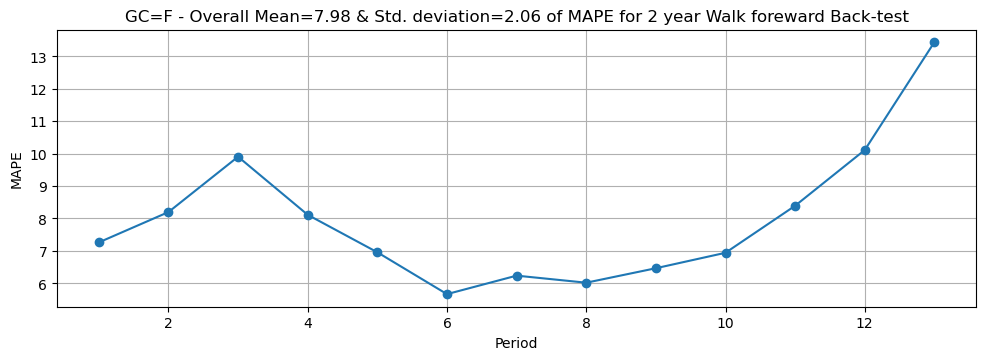

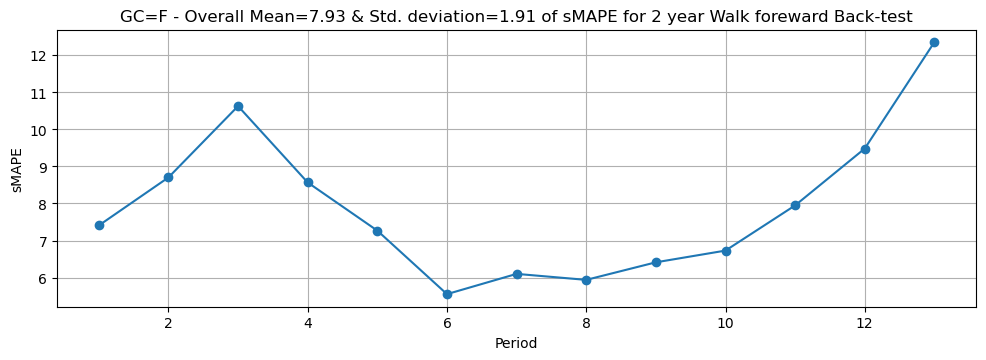

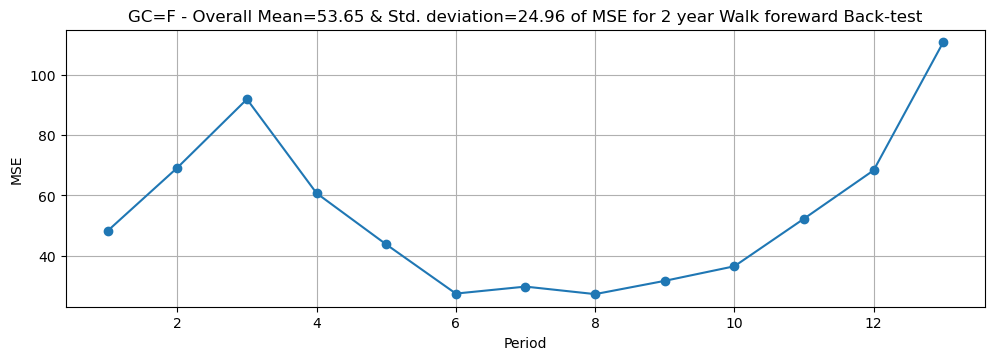

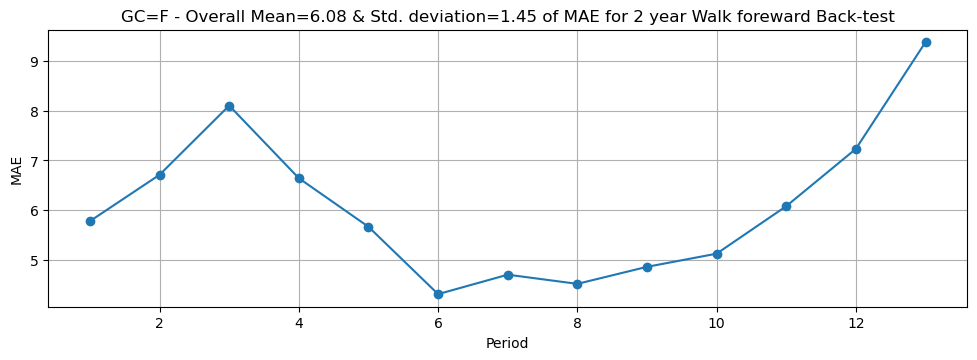

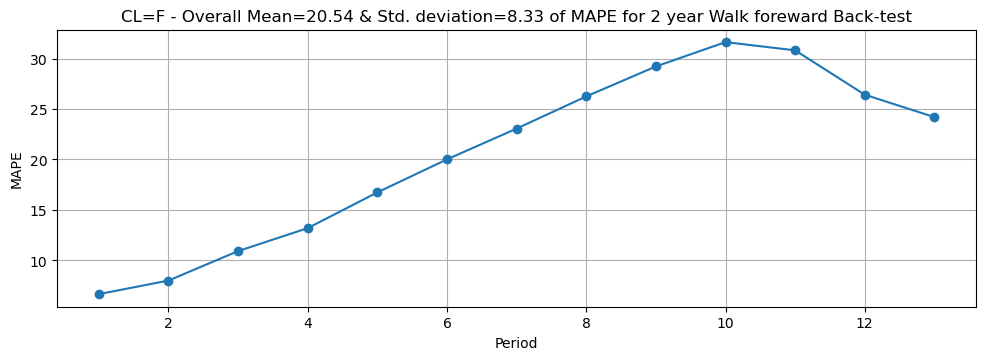

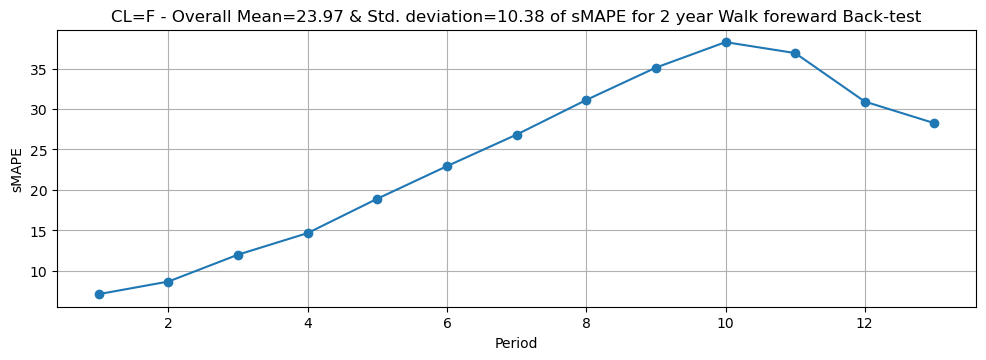

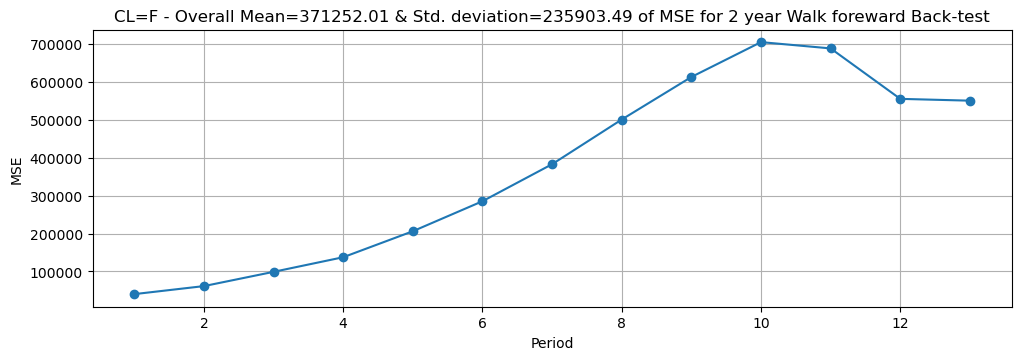

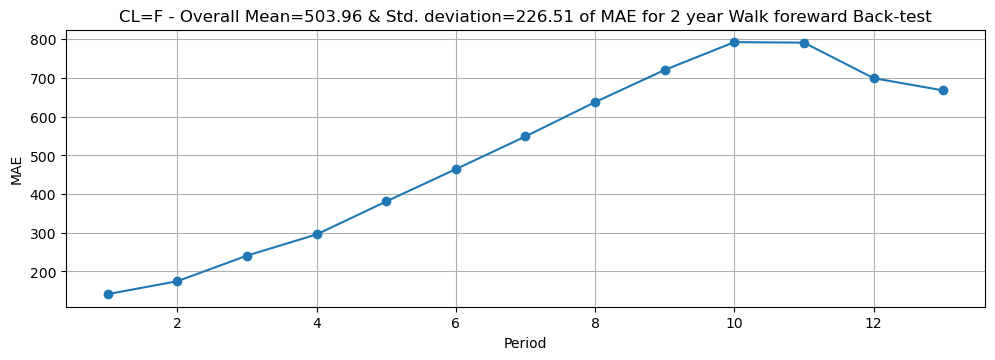

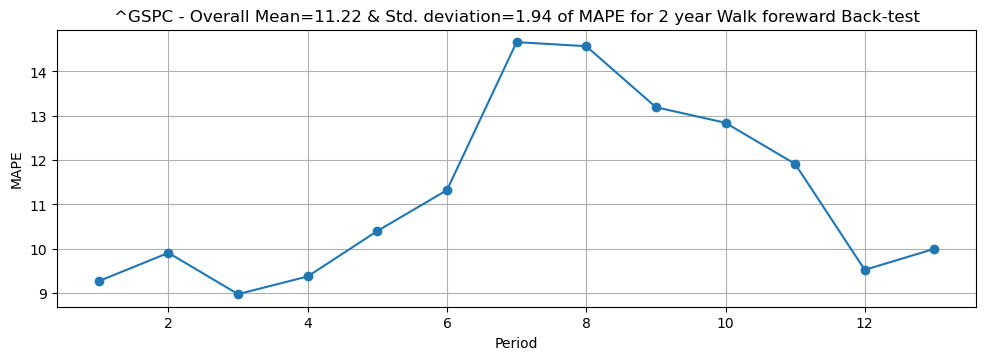

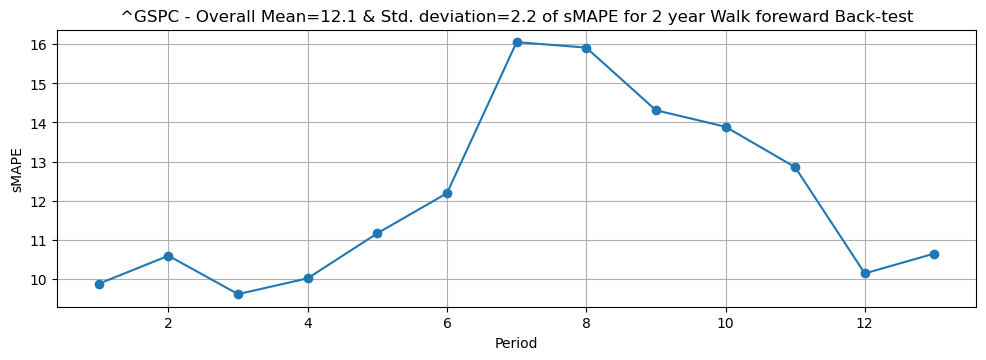

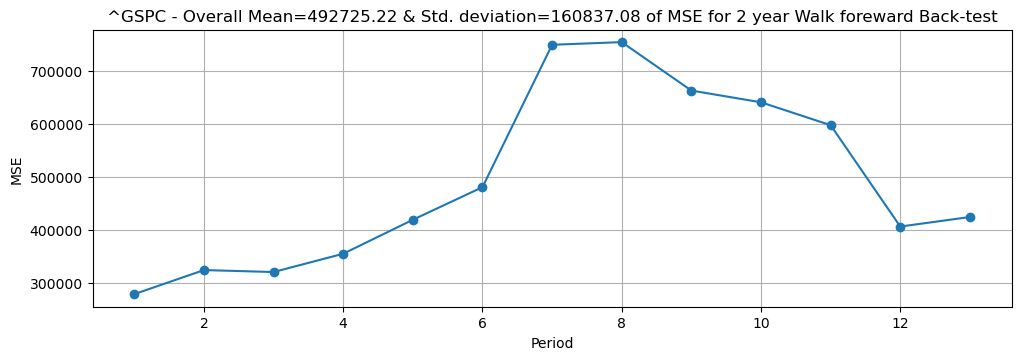

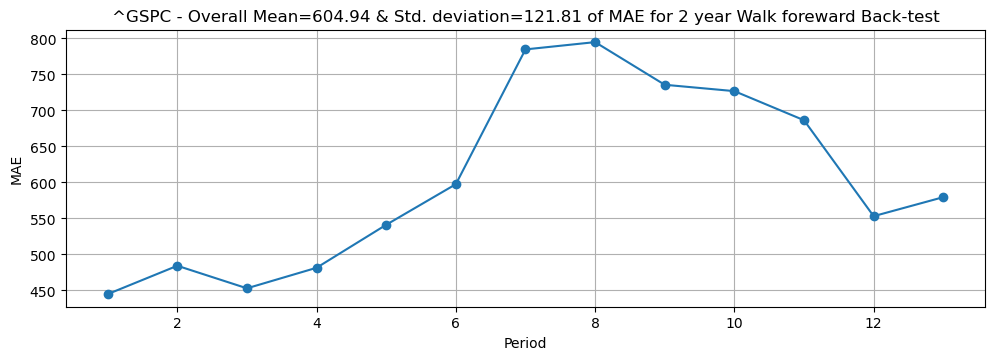

In [14]:
dic = {
    'Product':[],
    'Avg. MAPE':[],
    'Std.Dev. of Avg. MAPE':[],
    'Avg. sMAPE':[],
    'Std.Dev. of Avg. sMAPE':[],
    'Avg. MSE':[],
    'Std.Dev. of Avg. MSE':[],
    'Avg. MAE':[],
    'Std.Dev. of Avg. MAE':[],
       }
BTinfo = pd.DataFrame(dic)

mape_df = pd.DataFrame(Mape_dic, index=data['unique_id'].unique()).transpose()
smape_df = pd.DataFrame(sMape_dic, index=data['unique_id'].unique()).transpose()
mse_df = pd.DataFrame(Mse_dic, index=data['unique_id'].unique()).transpose()
mae_df = pd.DataFrame(Mae_dic, index=data['unique_id'].unique()).transpose()

os.makedirs(f'{path}/error_images', exist_ok=True)

for ind in data_index.index:
    item = data_index['unique_id'][ind]
    mypath = f'{path}/error_images/{item}'

    mape_mean, mape_std = error_fig(mape_df[item], item, mypath, 'MAPE')
    smape_mean, smape_std = error_fig(smape_df[item], item, mypath, 'sMAPE')
    mse_mean, mse_std = error_fig(mse_df[item], item, mypath, 'MSE')
    mae_mean, mae_std = error_fig(mae_df[item], item, mypath, 'MAE')

    bt_list = []
    bt_list.insert(0, data_index['unique_id'][ind])
    bt_list.insert(1, mape_mean)
    bt_list.insert(2, mape_std)
    bt_list.insert(3, smape_mean)
    bt_list.insert(4, smape_std)
    bt_list.insert(5, mse_mean)
    bt_list.insert(6, mse_std)
    bt_list.insert(7, mae_mean)
    bt_list.insert(8, mae_std)
        
    BTinfo.loc[ind] = bt_list
    
BTinfo.to_excel(f'{path}/BTinfo.xlsx', index=False)